## **Positional Encoding**

Unlike RNNs, which recurrently process
tokens of a sequence one by one,
self-attention ditches
sequential operations in favor of
parallel computation.
Note, however, that self-attention by itself
does not preserve the order of the sequence.
What do we do if it really matters
that the model knows in which order
the input sequence arrived?

The dominant approach for preserving
information about the order of tokens
is to represent this to the model
as an additional input associated
with each token.
These inputs are called *positional encodings*.
and they can either be learned or fixed a priori.
We now describe a simple scheme for fixed positional encodings
based on sine and cosine functions `Vaswani.Shazeer.Parmar.ea.2017`.

Suppose that the input representation
$\mathbf{X} \in \mathbb{R}^{n \times d}$
contains the $d$-dimensional embeddings
for $n$ tokens of a sequence.
The positional encoding outputs
$\mathbf{X} + \mathbf{P}$
using a positional embedding matrix
$\mathbf{P} \in \mathbb{R}^{n \times d}$ of the same shape,
whose element on the $i^\mathrm{th}$ row
and the $(2j)^\mathrm{th}$
or the $(2j + 1)^\mathrm{th}$ column is

$$\begin{aligned} p_{i, 2j} &= \sin\left(\frac{i}{10000^{2j/d}}\right),\\p_{i, 2j+1} &= \cos\left(\frac{i}{10000^{2j/d}}\right).\end{aligned}$$

At first glance,
this trigonometric-function
design looks weird.
Before explanations of this design,
let's first implement it in the following `PositionalEncoding` class.

In [3]:
import math
import torch
from torch import nn
import matplotlib.pyplot as plt

In [4]:
class PositionalEncoding(nn.Module):
    """Positional encoding."""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        # Create a long enough P
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(-1, 1) / torch.pow(10000, torch.arange(0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

In the positional embedding matrix $\mathbf{P}$,
rows correspond to positions within a sequence
and columns represent different positional encoding dimensions.
In the example below,
we can see that
the $6^{\mathrm{th}}$ and the $7^{\mathrm{th}}$
columns of the positional embedding matrix
have a higher frequency than
the $8^{\mathrm{th}}$ and the $9^{\mathrm{th}}$
columns.
The offset between
the $6^{\mathrm{th}}$ and the $7^{\mathrm{th}}$ (same for the $8^{\mathrm{th}}$ and the $9^{\mathrm{th}}$) columns
is due to the alternation of sine and cosine functions.

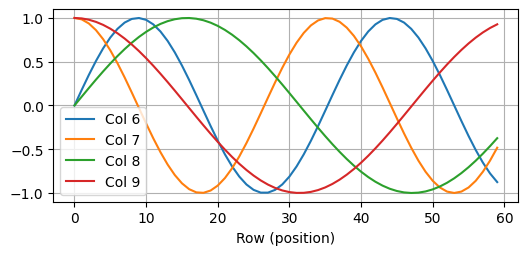

In [26]:
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]
plt.figure(figsize=(6, 2.5))
plt.plot(torch.arange(num_steps), P[0, :, 6:10], label=["Col %d" % d for d in torch.arange(6, 10)])
plt.xlabel('Row (position)')
plt.legend()
plt.grid()
plt.show()

### Absolute Positional Information

To see how the monotonically decreased frequency
along the encoding dimension relates to absolute positional information,
let's print out [**the binary representations**] of $0, 1, \ldots, 7$.
As we can see, the lowest bit, the second-lowest bit,
and the third-lowest bit alternate on every number,
every two numbers, and every four numbers, respectively.


In [10]:
for i in range(8):
    print(f'{i} in binary is {i:>03b}')

0 in binary is 000
1 in binary is 001
2 in binary is 010
3 in binary is 011
4 in binary is 100
5 in binary is 101
6 in binary is 110
7 in binary is 111


In binary representations, a higher bit
has a lower frequency than a lower bit.
Similarly, as demonstrated in the heat map below, the positional encoding decreases frequencies along the encoding dimension by using trigonometric functions. Since the outputs are float numbers, such continuous representations are more space-efficient than binary representations.


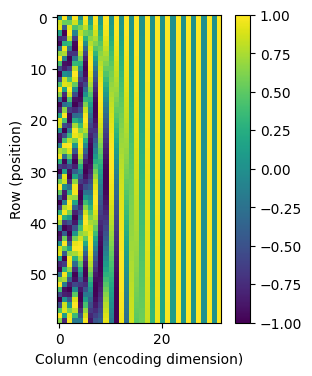

In [27]:
P = P[0, :, :].unsqueeze(0).unsqueeze(0)
plt.figure(figsize=(3.5, 4))
plt.imshow(P[0,0,:,:])
plt.xlabel('Column (encoding dimension)')
plt.ylabel('Row (position)')
plt.colorbar()
plt.show()

### Relative Positional Information

Besides capturing absolute positional information,
the above positional encoding
also allows
a model to easily learn to attend by relative positions.
This is because
for any fixed position offset $\delta$,
the positional encoding at position $i + \delta$
can be represented by a linear projection
of that at position $i$.


This projection can be explained
mathematically.
Denoting
$\omega_j = 1/10000^{2j/d}$,
any pair of $(p_{i, 2j}, p_{i, 2j+1})$
in :eqref:`eq_positional-encoding-def`
can
be linearly projected to $(p_{i+\delta, 2j}, p_{i+\delta, 2j+1})$
for any fixed offset $\delta$:

$$\begin{aligned}
&\begin{bmatrix} \cos(\delta \omega_j) & \sin(\delta \omega_j) \\  -\sin(\delta \omega_j) & \cos(\delta \omega_j) \\ \end{bmatrix}
\begin{bmatrix} p_{i, 2j} \\  p_{i, 2j+1} \\ \end{bmatrix}\\
=&\begin{bmatrix} \cos(\delta \omega_j) \sin(i \omega_j) + \sin(\delta \omega_j) \cos(i \omega_j) \\  -\sin(\delta \omega_j) \sin(i \omega_j) + \cos(\delta \omega_j) \cos(i \omega_j) \\ \end{bmatrix}\\
=&\begin{bmatrix} \sin\left((i+\delta) \omega_j\right) \\  \cos\left((i+\delta) \omega_j\right) \\ \end{bmatrix}\\
=&
\begin{bmatrix} p_{i+\delta, 2j} \\  p_{i+\delta, 2j+1} \\ \end{bmatrix},
\end{aligned}$$

where the $2\times 2$ projection matrix does not depend on any position index $i$.

## Summary

In self-attention, the queries, keys, and values all come from the same place.
Both CNNs and self-attention enjoy parallel computation
and self-attention has the shortest maximum path length.
However, the quadratic computational complexity
with respect to the sequence length
makes self-attention prohibitively slow
for very long sequences.
To use the sequence order information,
we can inject absolute or relative positional information
by adding positional encoding to the input representations.